In [1]:
import time
# import warnings
# warnings.simplefilter('ignore')
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from estimation_model import arrange_feature, scale, select_feature, divide_mealiness, optimize_hyperparameter, calc_metrics


In [3]:
# 分析データに関する設定
SEED = 202120971 #これを基本的に使用
MEALINESS = 15
# MEALINESS = 20
# MEALINESS = 25

# SMOTEの近傍数
N = 3

## 特徴量算出

In [4]:
# 特徴量の整理
feature_conv, target_df = arrange_feature(METHOD=0)
feature_new, target_df = arrange_feature(METHOD=1)

In [5]:
%%time
acc_conv, f1_conv = calc_metrics(feature_df=feature_conv,target_df=target_df, THRESH_RANGE=range(10,26))
acc_new, f1_new = calc_metrics(feature_df=feature_new,target_df=target_df, THRESH_RANGE=range(10,26))

/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.

CPU times: user 1min 55s, sys: 47.8 s, total: 2min 43s
Wall time: 2min 16s


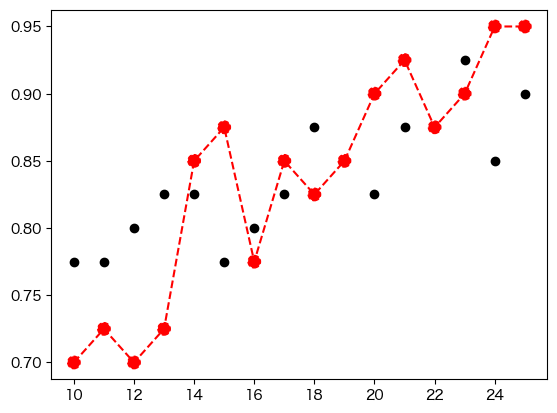

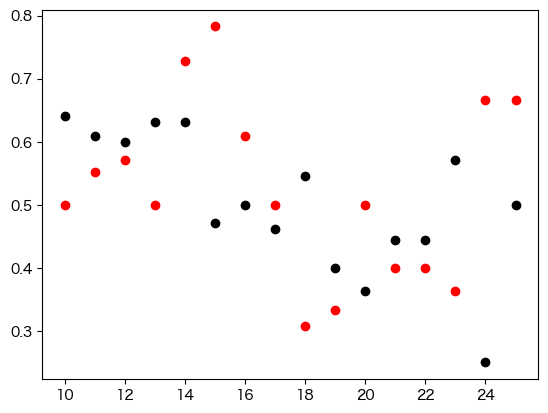

In [6]:
plt.scatter(range(10,26),acc_conv,color='k')
plt.plot(range(10,26),acc_new,color='r',linestyle='dashed')
plt.scatter(range(10,26),acc_new,color='r',linestyle='dashed',s=80)
plt.show()
plt.scatter(range(10,26),f1_conv,color='k')
plt.scatter(range(10,26),f1_new,color='r')

## 従来法での分類モデルの構築

In [331]:
##### 標準化
X_train_scale, X_test_scale, y_train, y_test = scale(feature_df=feature_conv, target_df=target_df)


##### 変数選択
X_train_scale, X_test_scale = select_feature(X_train_scale=X_train_scale, X_test_scale=X_test_scale, y_train=y_train)


##### 目的変数のバイナリー化
y_train = divide_mealiness(y_train,THRESH=MEALINESS).astype('int')
y_test = divide_mealiness(y_test,THRESH=MEALINESS).astype('int')

##### 目的変数のオーバーサンプリング
smote = SMOTE(sampling_strategy='minority', random_state=SEED,k_neighbors=N,n_jobs=-1)
X_train_scale, y_train = smote.fit_resample(X_train_scale, y_train)
y_train.astype('int')


##### ハイパーパラメータの最適化
param_pls = {'n_components':[i for i in range(1,100)]}
param_svm = {
    # 'C':[i/10 for i in range(1,201)],
    # 'kernel':['rbf'],
    # 'gamma':[1e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5],
    'kernel':['poly'],
    'degree':[i for i in range(1,13)]
}
param_ann = {'hidden_layer_sizes':[(55,),(15,),(6,)],#(88,),(44,), 
             'activation':['relu'],
             'solver':['adam'],
             'alpha':[1000,100,10,1,1e-2,1e-3,1e-4],
             'batch_size':[25,50,75,100]
            }

results_pls, results_svm, results_ann = optimize_hyperparameter(
    param_pls = param_pls, 
    param_svm = param_svm,
    param_ann = param_ann,
    X_train_scale = X_train_scale,
    y_train = y_train
)

# 各モデルの最適パラメータの表示
print('Best Parameter of PLS')
print(results_pls.best_params_)
print()
print('Best Parameter of SVM')
print(results_svm.best_params_)
print()
print('Best Parameter of ANN')
print(results_ann.best_params_)
print()

Best Parameter of PLS
{'n_components': 11}

Best Parameter of SVM
{'degree': 2, 'kernel': 'poly'}

Best Parameter of ANN
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 25, 'hidden_layer_sizes': (15,), 'solver': 'adam'}



In [332]:
%%time

##### 最適なハイパーパラメータでモデル構築

# PLS
pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
model_PLS = pls.fit(X_train_scale,y_train)

# SVM
svm = SVC(
#     kernel='rbf',
#     C=results_svm.best_params_['C'], 
    # gamma=results_svm.best_params_['gamma'],
    kernel='poly',
    degree=results_svm.best_params_['degree'],
)
model_SVM = svm.fit(X_train_scale, y_train)

# ANN
ann = MLPClassifier(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                   activation=results_ann.best_params_['activation'],
                   solver=results_ann.best_params_['solver'],
                   alpha=results_ann.best_params_['alpha'],
                   batch_size=results_ann.best_params_['batch_size'],
                   random_state=SEED
                  )

model_ANN = ann.fit(X_train_scale, y_train)

CPU times: user 458 ms, sys: 274 ms, total: 732 ms
Wall time: 182 ms


In [333]:
##### モデルの予測 #####

# trainの予測
y_pred_train_ANN = model_ANN.predict(X_train_scale).flatten()
y_pred_train_SVM = model_SVM.predict(X_train_scale).flatten()
y_pred_train_PLS = (model_PLS.predict(X_train_scale).flatten() > 0.5).astype('uint8')

# testの予測
y_pred_SVM = model_SVM.predict(X_test_scale).flatten()
y_pred_ANN = model_ANN.predict(X_test_scale).flatten()
y_pred_PLS = (model_PLS.predict(X_test_scale).flatten() > 0.5).astype('uint8')


tmp_conv = pd.DataFrame(
    [
        [
    accuracy_score(y_train,y_pred_train_PLS),
    accuracy_score(y_test,y_pred_PLS),
    accuracy_score(y_train,y_pred_train_SVM),
    accuracy_score(y_test,y_pred_SVM),
    accuracy_score(y_train,y_pred_train_ANN),
    accuracy_score(y_test,y_pred_ANN),
        ],
        
        [
    f1_score(y_train,y_pred_train_PLS),
    f1_score(y_test,y_pred_PLS),
    f1_score(y_train,y_pred_train_SVM),
    f1_score(y_test,y_pred_SVM),
    f1_score(y_train,y_pred_train_ANN),
    f1_score(y_test,y_pred_ANN),
        ]
    ]
)

tmp_conv.index = ['Accuracy','F1 score']
tmp_conv.columns = ['PLS_train','PLS_test','SVM_train','SVM_test','ANN_train','ANN_test']

tmp = pd.DataFrame(confusion_matrix(y_test,y_pred_ANN))
tmp.columns=['予測された非粉質化','予測された粉質化']
tmp.index=['実際は非粉質化','実際は粉質化']
# tmp


## レーザー散乱法での分類モデルの構築

In [334]:
##### 標準化
X_train_scale, X_test_scale, y_train, y_test = scale(feature_df=feature_new, target_df=target_df)


##### 変数選択
X_train_scale, X_test_scale = select_feature(X_train_scale=X_train_scale, X_test_scale=X_test_scale, y_train=y_train)


##### 目的変数のバイナリー化
y_train = divide_mealiness(y_train,THRESH=MEALINESS).astype('int')
y_test = divide_mealiness(y_test,THRESH=MEALINESS).astype('int')

##### 目的変数のオーバーサンプリング
smote = SMOTE(sampling_strategy='minority', random_state=SEED,k_neighbors=N,n_jobs=-1)
X_train_scale, y_train = smote.fit_resample(X_train_scale, y_train)
y_train.astype('int')

##### ハイパーパラメータの最適化
param_pls = {'n_components':[i for i in range(1,100)]}
param_svm = {
    # 'C':[i/10 for i in range(1,501)],
    # 'kernel':['rbf'],
    # 'gamma':[1e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5],
    
    'kernel':['poly'],
    'degree':[i for i in range(1,13)]
}
param_ann = {'hidden_layer_sizes':[(55,),(15,),(6,)],#, 
             'activation':['relu'],
             'solver':['adam'],
             'alpha':[1000,100,10,1,1e-2,1e-3,1e-4],
             'batch_size':[25,50,75,100]
            }

results_pls, results_svm, results_ann = optimize_hyperparameter(
    param_pls = param_pls, 
    param_svm = param_svm,
    param_ann = param_ann,
    X_train_scale = X_train_scale,
    y_train = y_train
)

# 各モデルの最適パラメータの表示
print('Best Parameter of PLS')
print(results_pls.best_params_)
print()
print('Best Parameter of SVM')
print(results_svm.best_params_)
print()
print('Best Parameter of ANN')
print(results_ann.best_params_)
print()

Best Parameter of PLS
{'n_components': 6}

Best Parameter of SVM
{'degree': 1, 'kernel': 'poly'}

Best Parameter of ANN
{'activation': 'relu', 'alpha': 0.01, 'batch_size': 25, 'hidden_layer_sizes': (55,), 'solver': 'adam'}



In [335]:
%%time

##### 最適なハイパーパラメータでモデル構築

# PLS
pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
model_PLS = pls.fit(X_train_scale,y_train)

# SVM
svm = SVC(
    # kernel='rbf',
    # C=results_svm.best_params_['C'], 
    # gamma=results_svm.best_params_['gamma'],
    
    kernel='poly',
    degree=results_svm.best_params_['degree'],
    
)
model_SVM = svm.fit(X_train_scale, y_train)

# ANN
ann = MLPClassifier(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                   activation=results_ann.best_params_['activation'],
                   solver=results_ann.best_params_['solver'],
                   alpha=results_ann.best_params_['alpha'],
                   batch_size=results_ann.best_params_['batch_size'],
                   random_state=SEED
                  )

model_ANN = ann.fit(X_train_scale, y_train)

CPU times: user 950 ms, sys: 567 ms, total: 1.52 s
Wall time: 407 ms


In [336]:
##### モデルの予測 #####

# trainの予測
y_pred_train_ANN = model_ANN.predict(X_train_scale).flatten()
y_pred_train_SVM = model_SVM.predict(X_train_scale).flatten()
y_pred_train_PLS = (model_PLS.predict(X_train_scale).flatten() > 0.5).astype('int')
y_pred_train_en = pd.DataFrame([y_pred_train_PLS,y_pred_train_SVM,y_pred_train_ANN]).mode().values.flatten()

# testの予測
y_pred_SVM = model_SVM.predict(X_test_scale).flatten()
y_pred_ANN = model_ANN.predict(X_test_scale).flatten()
y_pred_PLS = (model_PLS.predict(X_test_scale).flatten() > 0.5).astype('int')
y_pred_en = pd.DataFrame([y_pred_PLS,y_pred_SVM,y_pred_ANN]).mode().values.flatten()


tmp_new = pd.DataFrame(
    [
        [
    accuracy_score(y_train,y_pred_train_PLS),
    accuracy_score(y_test,y_pred_PLS),
    accuracy_score(y_train,y_pred_train_SVM),
    accuracy_score(y_test,y_pred_SVM),
    accuracy_score(y_train,y_pred_train_ANN),
    accuracy_score(y_test,y_pred_ANN),
    # accuracy_score(y_train,y_pred_train_en),
    # accuracy_score(y_test,y_pred_en),
        ],
        
        [
    f1_score(y_train,y_pred_train_PLS),
    f1_score(y_test,y_pred_PLS),
    f1_score(y_train,y_pred_train_SVM),
    f1_score(y_test,y_pred_SVM),
    f1_score(y_train,y_pred_train_ANN),
    f1_score(y_test,y_pred_ANN),
    # f1_score(y_train,y_pred_train_en),
    # f1_score(y_test,y_pred_en),
        ]
    ]
)

tmp_new.index = ['Accuracy','F1 score']
tmp_new.columns = ['PLS_train','PLS_test','SVM_train','SVM_test','ANN_train','ANN_test',
                   # 'Ensem_train','Ensem_test'
                  ]
# tmp_new



In [337]:
tmp_conv

,PLS_train,PLS_test,SVM_train,SVM_test,ANN_train,ANN_test
Accuracy,0.909774,0.57500,0.909774,0.725000,1.0,0.775000
F1 score,0.914286,0.26087,0.915493,0.421053,1.0,0.470588


In [338]:
tmp_new

,PLS_train,PLS_test,SVM_train,SVM_test,ANN_train,ANN_test
Accuracy,0.913534,0.775,0.894737,0.875000,1.0,0.775000
F1 score,0.917563,0.640,0.898551,0.782609,1.0,0.526316


In [327]:
tmp = pd.DataFrame(confusion_matrix(y_test,y_pred_SVM))
tmp.columns=['予測された非粉質化','予測された粉質化']
tmp.index=['実際は非粉質化','実際は粉質化']
tmp

,予測された非粉質化,予測された粉質化
実際は非粉質化,26,5
実際は粉質化,0,9


1.0

In [14]:
y_pred_ANN

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0])

In [15]:
y_pred_SVM

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [16]:
y_pred_PLS

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], dtype=uint8)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,1,1,0,0
